In [5]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from math import sqrt
from sklearn.metrics import mean_squared_error ,mean_absolute_error,explained_variance_score,mean_squared_log_error,r2_score,f1_score
from sklearn.model_selection import train_test_split
%matplotlib inline

In [6]:
data = pd.read_csv('../Files tcc/data.csv',index_col=['Data'])

In [22]:
data.head()


,Fechamento
Data,
01-01-2015,314.25
02-01-2015,315.03
03-01-2015,281.08
04-01-2015,264.20
05-01-2015,274.47


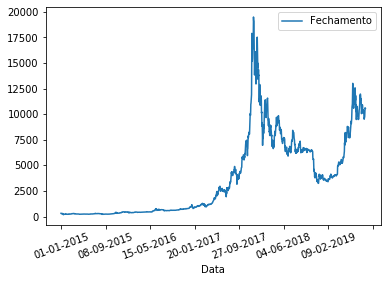

In [23]:
data.plot()
plt.xticks(rotation=20)
plt.savefig('Data.png')

In [9]:
df = data[['Fechamento']]
dataset = df.values
dataset = dataset.astype('float32')

In [10]:
train_size = int(len(dataset)*0.67)
teste_size = len(dataset) - train_size
train,test = dataset[0:train_size,:],dataset[train_size:len(dataset),:]
print(len(train), len(test))

1145 564


In [11]:
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [12]:
def antes(dataset,look_back=1):
    dia_atras = []
    for i in range(len(dataset)-look_back-1):
        dia_atras.append(dataset[i-1+look_back, 0])
    
    return np.array(dia_atras)

In [13]:
look_back=3
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test,look_back=look_back)
dia_atras = antes(test,look_back=look_back)
print(len(trainX),len(trainY),len(testX),len(testY),len(dia_atras))

1141 1141 560 560 560


In [14]:
regressor = xgb.XGBRegressor(n_estimators=1000)
regressor.fit(trainX, trainY,eval_set=[(trainX, trainY), (testX, testY)],early_stopping_rounds=50,verbose=False)

[16:56:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [15]:
predicao = regressor.predict(testX)

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
resultado = pd.DataFrame(testY,columns=['Esperado'])
resultado['Predito'] = predicao
resultado.index = data.tail(560).index

XGBOOST
MAPE: 96.287
Desvio: 3.713
MSE: 151249.656
RMSE: 388.908
MAE: 269.842
MSLE: 0.002
R2 score: 97.283
Explaine Variance Score: 97.286


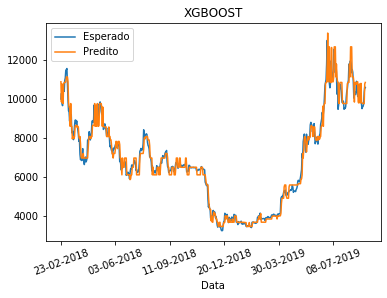

In [18]:
print('XGBOOST')
print("MAPE: %.3f"%(100-mean_absolute_percentage_error(testY,predicao)))
print("Desvio: %.3f"%mean_absolute_percentage_error(testY,predicao))
print("MSE: %.3f"%mean_squared_error(testY,predicao))
print("RMSE: %.3f"%sqrt(mean_squared_error(testY,predicao)))
print("MAE: %.3f"%mean_absolute_error(testY,predicao))
print("MSLE: %.3f"%mean_squared_log_error(testY,predicao))
print("R2 score: %.3f"%(r2_score(testY,predicao)*100))
print("Explaine Variance Score: %.3f"%(explained_variance_score(testY,predicao)*100))
resultado.plot()
plt.xticks(rotation=20)
plt.title('XGBOOST')
plt.savefig('XGBOOST_teste.png')  

MAPE: 94.597
Desvio: 5.403
RMSE: 401.103
Fechamento [7424.29]
Predito [7825.393]


Text(0.5, 1.0, 'Comparação do FechamentoXPredição')

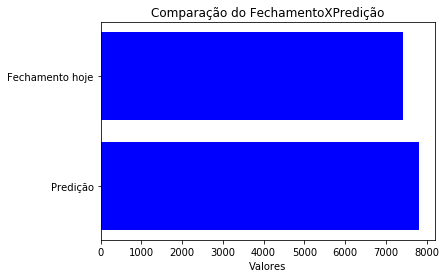

In [19]:
entrada = np.array([[7463.11,7761.24,7569.63]])
fechamentohoje = [7424.29]
predicaohoje = regressor.predict(entrada)
print("MAPE: %.3f"%(100-mean_absolute_percentage_error(fechamentohoje,predicaohoje)))
print("Desvio: %.3f"%mean_absolute_percentage_error(fechamentohoje,predicaohoje))
print("RMSE: %.3f"%sqrt(mean_squared_error(fechamentohoje,predicaohoje)))
print("Fechamento %s"%fechamentohoje)
print("Predito %s"%predicaohoje)

vetorgrafico = { "Predição": predicaohoje[0] , "Fechamento hoje": fechamentohoje[0]}
colunas = [i for i in vetorgrafico.keys()]
valor = [j for j in vetorgrafico.values()]
popPos = np.arange(len(colunas))
plt.barh(popPos, valor, align='center', color='blue')
plt.yticks(popPos, colunas)
plt.xlabel('Valores')
plt.title('Comparação do FechamentoXPredição')